当前工作目录: /mnt/public/wangsiyuan/HunyuanVideo_efficiency/plots
文件存在: /home/hanling/HunyuanVideo_efficiency/analysis_ci/analysis_results_15hz_1x_ssim/metrics.csv
文件存在: /home/hanling/HunyuanVideo_efficiency/analysis_ci/analysis_results_15hz_2x_ssim/metrics.csv
文件存在: /home/hanling/HunyuanVideo_efficiency/analysis_ci/analysis_results_15hz_4x_ssim/metrics.csv
指标: lpips, 设置: 4Hz, 拟合参数: a=-0.0712, b=0.1214, R²=0.2324
指标: lpips, 设置: 2Hz, 拟合参数: a=-0.2447, b=0.3004, R²=0.8516
指标: lpips, 设置: 1Hz, 拟合参数: a=-0.4111, b=0.4766, R²=0.9206


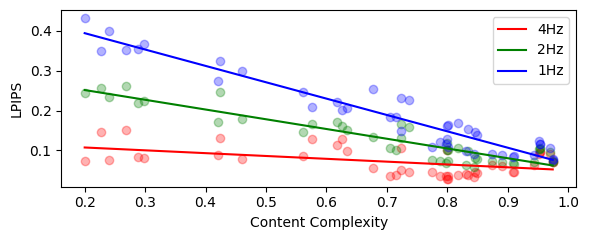

Metric: lpips, 4Hz, y=0.05 对应的 tile_ci: None
Metric: lpips, 2Hz, y=0.05 对应的 tile_ci: None
Metric: lpips, 1Hz, y=0.05 对应的 tile_ci: None


In [19]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 定义拟合函数，这里以线性函数为例
def linear_func(x, a, b):
    return a * x + b

# 文件路径列表
file_paths = [
    '/home/hanling/HunyuanVideo_efficiency/analysis_ci/analysis_results_15hz_1x_ssim/metrics.csv',
    '/home/hanling/HunyuanVideo_efficiency/analysis_ci/analysis_results_15hz_2x_ssim/metrics.csv',
    '/home/hanling/HunyuanVideo_efficiency/analysis_ci/analysis_results_15hz_4x_ssim/metrics.csv'
]

# 标签列表，用于图例
colors = ['r', 'g', 'b']

# 存储拟合参数
fit_params = {'psnr': [], 'ssim': [], 'lpips': []}

# 存储每个文件的数据
data_list = []

# 打印当前工作目录
print(f"当前工作目录: {os.getcwd()}")

# 检查每个文件是否存在并读取
for path in file_paths:
    if not os.path.isfile(path):
        print(f"文件不存在: {path}")
    else:
        print(f"文件存在: {path}")
        try:
            df = pd.read_csv(path)
            
            # 确保 'tile_ci' 被转换为浮点数
            df['tile_ci'] = pd.to_numeric(df['tile_ci'], errors='coerce')
            
            # 选择数值类型的列
            numeric_cols = ['tile_ci', 'psnr', 'ssim', 'lpips']
            df_numeric = df[numeric_cols].dropna()  # 去除可能的NaN值
            
            # 按 tile_ci 分组，计算每个 tile_ci 的平均值
            df_grouped = df_numeric.groupby('tile_ci').mean().reset_index()
            data_list.append(df_grouped)
        except Exception as e:
            print(f"读取文件失败 {path}: {e}")

# 确保所有文件都存在后继续
if len(data_list) != len(file_paths):
    print("部分文件缺失，无法继续拟合和绘图。")
    sys.exit(1)

# 定义指标
metrics = ['lpips']

labels = ['4Hz', '2Hz', '1Hz']
plt.figure(figsize=(6, 2.5))
# plt.subplot(1,2,1)
# 对每个指标进行独立绘图
for metric in metrics:
    for i, df in enumerate(data_list):
        x = df['tile_ci'].values
        y = df[metric].values
        # 拟合
        try:
            popt, _ = curve_fit(linear_func, x, y, method='dogbox',sigma=1)
            fit_params[metric].append(popt)
            # 生成拟合曲线
            x_fit = np.linspace(x.min(), x.max(), 100)
            y_fit = linear_func(x_fit, *popt)
            plt.plot(x_fit, y_fit, color=colors[i], label=labels[i])
            # 输出拟合参数和拟合质量
            a, b = popt
            y_pred = linear_func(x, a, b)
            r2 = np.corrcoef(y, y_pred)[0, 1]**2
            print(f"指标: {metric}, 设置: {labels[i]}, 拟合参数: a={a:.4f}, b={b:.4f}, R²={r2:.4f}")
        except Exception as e:
            print(f"拟合失败 for {metric} in {labels[i]}: {e}")
            fit_params[metric].append([np.nan, np.nan])
        
        # 绘制原始数据点
        plt.scatter(x, y, color=colors[i], alpha=0.3)
    plt.xlabel('Content Complexity')
    plt.ylabel('LPIPS')
    plt.legend()
    plt.tight_layout()

# plt.subplot(1,2,2)
# x=[0,0.3,0.3,0.6,0.6,1]
# y=[1,1,2,2,4,4]
# plt.plot(x, y, color='black',label='Low Complexity')
# y2=[1,1,2,2,4,4]
# plt.plot(x, y, color='black')
# plt.tight_layout()

plt.savefig('content_complexity.pdf')
plt.show()

# 定义函数，根据 y 值返回 x 值
# 这里使用线性函数，需要求解 a*x + b = y
def get_tile_ci_linear(y_values):
    results = {}
    for metric in metrics:
        results[metric] = []
        for j in range(len(file_paths)):
            params = fit_params[metric][j]
            a, b = params
            y = y_values.get(metric, None)
            if y is None or np.isnan(a) or np.isnan(b):
                results[metric].append(None)
                continue
            # 解方程 a*x + b = y => x = (y - b) / a
            if a == 0:
                results[metric].append(None)  # 避免除以零
                continue
            x_val = (y - b) / a
            # 检查x_val是否在tile_ci的范围内（假设为0到1）
            if 0 <= x_val <= 1:
                results[metric].append(x_val)
            else:
                results[metric].append(None)
    return results

# 示例：根据指定的 y 值获取 tile_ci
y_input = {
    'psnr': 30,
    'ssim': 0.85,
    'lpips': 0.05
}

tile_ci_results = get_tile_ci_linear(y_input)
for metric in metrics:
    for i, label in enumerate(labels):
        x_val = tile_ci_results[metric][i]
        print(f"Metric: {metric}, {label}, y={y_input[metric]} 对应的 tile_ci: {x_val}")
